In [38]:
import numpy as np
import bisect

from matplotlib import pyplot as plt
import matplotlib

In [2]:
from pixel3d import Pixel3D

In [3]:
from topologicalunionfind import TopologicalUnionFind

### Reading Cube

In [4]:
cube = np.array([[[3, 6, 9],
                  [3, 1, 5],
                  [3, 4, 3]],

                 [[8, 7, 4],
                  [8, 4, 5],
                  [4, 7, 5]],

                 [[7, 8, 2],
                  [2, 1, 5],
                  [6, 6, 7]]])

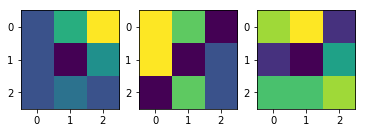

In [5]:
fig1 = plt.subplot(1, 3, 1)
fig1.imshow(cube[0])
fig2 = plt.subplot(1, 3, 2)
fig2.imshow(cube[1])
fig3 = plt.subplot(1, 3, 3)
fig3.imshow(cube[2])
plt.show()

### Getting Data

In [76]:
reverse = True
diagonal = False

In [77]:
if reverse:
    data = cube.max() - cube + 1
else:
    data = cube
data.shape

(3, 3, 3)

### Generating Input File

In [78]:
if reverse: 
    if diagonal:
        ainput = 'toy3dr.txt'
    else:
        ainput = 'toy3dr2.txt'
else:
    if diagonal:
        ainput = 'toy3d.txt'
    else:
        ainput = 'toy3d2.txt'

In [79]:
def write3dPath(f, data, i, j, k, ni, nj, nk):
    if ni < 0 or nj < 0 or nk < 0:
        return
    try:
        f.write('1 {} {} {} {} {} {} {}\n'.format(i, j, k, ni, nj, nk, max(data[i, j, k], data[ni, nj, nk])))
    except:
        pass

In [80]:
with open(ainput, 'w') as f:
    f.write(str(len(data.shape))+'\n')
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            for k in range(0, data.shape[2]):
                f.write('0 {} {} {} {}\n'.format(i, j, k, data[i, j, k]))
                write3dPath(f, data, i, j, k, i+1, j, k)
                write3dPath(f, data, i, j, k, i, j+1, k)
                write3dPath(f, data, i, j, k, i, j, k+1)
                if diagonal:
                    write3dPath(f, data, i, j, k, i, j+1, k+1)
                    write3dPath(f, data, i, j, k, i, j+1, k-1)
                    write3dPath(f, data, i, j, k, i+1, j, k+1)
                    write3dPath(f, data, i, j, k, i+1, j, k-1)
                    write3dPath(f, data, i, j, k, i+1, j+1, k)
                    write3dPath(f, data, i, j, k, i+1, j-1, k)

### Running

In [81]:
import subprocess

In [82]:
subprocess.run(['./perseusMac', 'nmfsimtop', ainput, ainput[:-4]])

CompletedProcess(args=['./perseusMac', 'nmfsimtop', 'toy3dr2.txt', 'toy3dr2'], returncode=0)

### Reading Output File

In [83]:
if reverse: 
    if diagonal:
        aoutput = 'toy3dr_0.txt'
    else:
        aoutput = 'toy3dr2_0.txt'
else:
    if diagonal:
        aoutput = 'toy3d_0.txt'
    else:
        aoutput = 'toy3d2_0.txt'

In [84]:
pd2 = []
with open(aoutput) as f:
    for l in f.readlines():
        info = l.split()
        pd2.append((int(info[0]), int(info[1])))
pd2 = sorted(pd2, key=lambda x:x[0])
pd2

[(1, -1), (2, 3), (2, 4), (3, 4), (3, 5)]

In [85]:
persistencePH = []
for birth, death in pd2:
    if reverse:
        nbirth = cube.max() - death + 1 if death != -1 else cube.min() 
        ndeath = cube.max() - birth + 1
    else:
        nbirth = birth + cube.min() - 1
        ndeath = death + cube.min() - 1 if death != -1 else cube.max()
    persistencePH.append((nbirth, ndeath))
persistencePH

[(1, 9), (7, 8), (6, 8), (6, 7), (5, 7)]

### Creating Pixel Objects

In [86]:
mat = []
for i in range(data.shape[0]):
    aslice = []
    for j in range(data.shape[1]):
        row = []
        for k in range(data.shape[2]):
            element = data[i][j][k]
            row.append(Pixel3D(i, j, k, element))
        aslice.append(row)
    mat.append(aslice)

In [87]:
arr = sorted([e for aslice in mat for row in aslice for e in row])
arr

[Pixel: [coordinates: (0, 0, 2); value: 1],
 Pixel: [coordinates: (1, 0, 0); value: 2],
 Pixel: [coordinates: (1, 1, 0); value: 2],
 Pixel: [coordinates: (2, 0, 1); value: 2],
 Pixel: [coordinates: (1, 0, 1); value: 3],
 Pixel: [coordinates: (1, 2, 1); value: 3],
 Pixel: [coordinates: (2, 0, 0); value: 3],
 Pixel: [coordinates: (2, 2, 2); value: 3],
 Pixel: [coordinates: (0, 0, 1); value: 4],
 Pixel: [coordinates: (2, 2, 0); value: 4],
 Pixel: [coordinates: (2, 2, 1); value: 4],
 Pixel: [coordinates: (0, 1, 2); value: 5],
 Pixel: [coordinates: (1, 1, 2); value: 5],
 Pixel: [coordinates: (1, 2, 2); value: 5],
 Pixel: [coordinates: (2, 1, 2); value: 5],
 Pixel: [coordinates: (0, 2, 1); value: 6],
 Pixel: [coordinates: (1, 0, 2); value: 6],
 Pixel: [coordinates: (1, 1, 1); value: 6],
 Pixel: [coordinates: (1, 2, 0); value: 6],
 Pixel: [coordinates: (0, 0, 0); value: 7],
 Pixel: [coordinates: (0, 1, 0); value: 7],
 Pixel: [coordinates: (0, 2, 0); value: 7],
 Pixel: [coordinates: (0, 2, 2);

### Getting Neighbors for a Pixel

In [88]:
def append3DNeighbor(neighbors, x, y, z):
    if x < 0 or y < 0 or z < 0:
        return
    try:
        neighbors.append(mat[x][y][z])
    except:
        pass

In [89]:
def get_neighbors(pixel, diagonal=False):
    neighbors = []
    x = pixel.getX()
    y = pixel.getY()
    z = pixel.getZ()
    append3DNeighbor(neighbors, x-1, y, z)
    append3DNeighbor(neighbors, x+1, y, z)
    append3DNeighbor(neighbors, x, y-1, z)
    append3DNeighbor(neighbors, x, y+1, z)
    append3DNeighbor(neighbors, x, y, z-1)
    append3DNeighbor(neighbors, x, y, z+1)
    if diagonal:
        append3DNeighbor(neighbors, x-1, y-1, z-1)
        append3DNeighbor(neighbors, x-1, y-1, z)
        append3DNeighbor(neighbors, x-1, y-1, z+1)
        append3DNeighbor(neighbors, x-1, y, z-1)
        append3DNeighbor(neighbors, x-1, y, z+1)
        append3DNeighbor(neighbors, x-1, y+1, z-1)
        append3DNeighbor(neighbors, x-1, y+1, z)
        append3DNeighbor(neighbors, x-1, y+1, z+1)
        append3DNeighbor(neighbors, x, y+1, z+1)
        append3DNeighbor(neighbors, x, y-1, z+1)
        append3DNeighbor(neighbors, x, y+1, z-1)
        append3DNeighbor(neighbors, x, y-1, z-1)
        append3DNeighbor(neighbors, x+1, y-1, z-1)
        append3DNeighbor(neighbors, x+1, y-1, z)
        append3DNeighbor(neighbors, x+1, y-1, z+1)
        append3DNeighbor(neighbors, x+1, y, z-1)
        append3DNeighbor(neighbors, x+1, y, z+1)
        append3DNeighbor(neighbors, x+1, y+1, z-1)
        append3DNeighbor(neighbors, x+1, y+1, z)
        append3DNeighbor(neighbors, x+1, y+1, z+1)
    return neighbors

In [90]:
set([len(get_neighbors(pixel)) for pixel in arr])

{3, 4, 5, 6}

In [91]:
set([len(get_neighbors(pixel, True)) for pixel in arr])

{7, 11, 17, 26}

### Creating Topological Union-find

In [92]:
tuf = TopologicalUnionFind()
tuf

<UnionFind:
	elts=[],
	siz=[],
	par=[],
n_elts=0,n_comps=0>

In [93]:
for pixel in arr:
    tuf.add(pixel, pixel.getV())
    for neighbor in get_neighbors(pixel, diagonal):
        tuf.union(pixel, neighbor, pixel.getV())

In [94]:
pd = tuf.persistence()
pd

[(1, inf), (2, 3), (2, 4), (3, 5), (3, 4)]

In [95]:
persistenceUF = []
for birth, death in pd:
    if reverse:
        nbirth = cube.max() - death + 1 if np.isfinite(death) else cube.min() 
        ndeath = cube.max() - birth + 1
    else:
        nbirth = birth
        ndeath = death if np.isfinite(death) else cube.max()
    persistenceUF.append((nbirth, ndeath))
persistenceUF

[(1, 9), (7, 8), (6, 8), (5, 7), (6, 7)]

### Visualization

In [96]:
y = np.arange(0, len(persistenceUF))

In [97]:
xmin = [birth for birth, death in persistenceUF]
xmax = [death for birth, death in persistenceUF]

In [98]:
if reverse:
    xlim = (max(xmax), min(xmin))
else:
    xlim = (min(xmin), max(xmax))

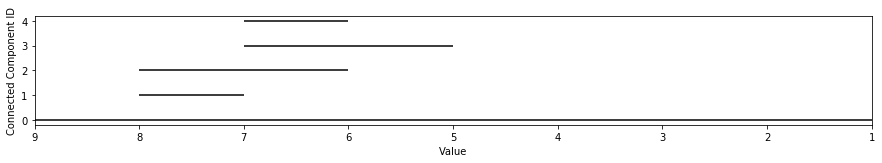

In [99]:
height = 2 + len(persistenceUF) // 10
plt.figure(figsize=(15,height))
plt.hlines(y=y, xmin=xmin, xmax=xmax)
plt.xlim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Value')
plt.ylabel('Connected Component ID')
plt.show()

In [100]:
xmin = [birth for birth, death in persistenceUF]
xmax = [death for birth, death in persistenceUF]

In [101]:
if reverse:
    xlim = (max(xmax)+1, min(xmin)-1)
    xmin, xmax = xmax, xmin
else:
    xlim = (min(xmin)-1, max(xmax)+1)

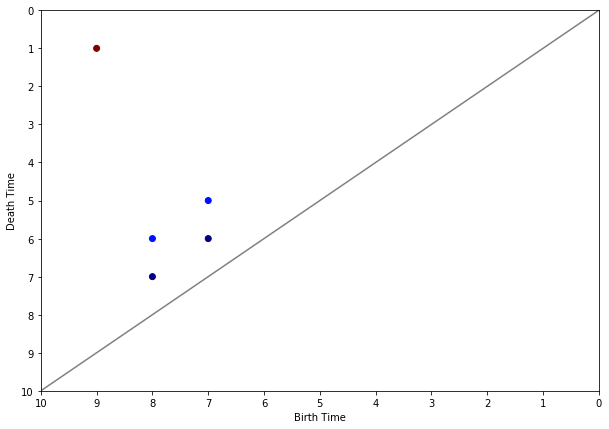

In [102]:
plt.figure(figsize=(10,7))
plt.scatter(xmin, xmax, c=np.array(xmax)-np.array(xmin), cmap='jet_r')
plt.xlim(xlim[0], xlim[1])
plt.ylim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Birth Time')
plt.ylabel('Death Time')
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], c='grey')
plt.show()

### Visualization 2

In [103]:
y = np.arange(0, len(persistencePH))

In [104]:
xmin = [birth for birth, death in persistencePH]
xmax = [death for birth, death in persistencePH]

In [105]:
if reverse:
    xlim = (max(xmax), min(xmin))
else:
    xlim = (min(xmin), max(xmax))

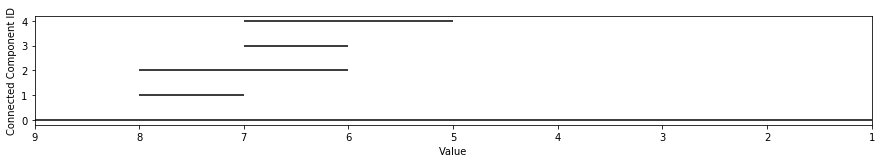

In [106]:
height = 2 + len(persistencePH) // 10
plt.figure(figsize=(15,height))
plt.hlines(y=y, xmin=xmin, xmax=xmax)
plt.xlim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Value')
plt.ylabel('Connected Component ID')
plt.show()

In [107]:
xmin = [birth for birth, death in persistencePH]
xmax = [death for birth, death in persistencePH]

In [108]:
if reverse:
    xlim = (max(xmax)+1, min(xmin)-1)
    xmin, xmax = xmax, xmin
else:
    xlim = (min(xmin)-1, max(xmax)+1)

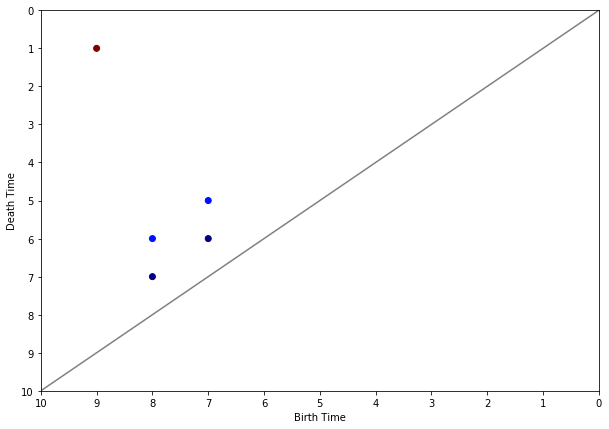

In [109]:
plt.figure(figsize=(10,7))
plt.scatter(xmin, xmax, c=np.array(xmax)-np.array(xmin), cmap='jet_r')
plt.xlim(xlim[0], xlim[1])
plt.ylim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Birth Time')
plt.ylabel('Death Time')
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], c='grey')
plt.show()